In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# %matplotlib inline

/Users/KimHongTae/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/KimHongTae/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# import xgboost
# mymodel = XGBClassifier(<my parameters>)
# mymodel.fit(train, labels )
# mymodel.predict(test)

# 1. Import Data & Determine attributes which need preprocessing 

## Dataset description
 - train_users: Train 단계에서 사용되는 user 데이터, Traffic 데이터와 Demographic 데이터로 구성되어 있음
 - test_users: Test 단계에서 사용되는 user 데이터, Train_users와 동일하나 예측 라벨인 country_destination이 없음
 - countries: 각 국가의 위도,경도,거리,면적,언어,levenstein dist.로 구성
 - sessions: 세션 단위로 수집된 유저 traffic 데이터, user id, session id 및 세션에서 발생한 event action에 대한 데이터
 - age_gender: age bucket, 예약 국가, 성별, 인구 수, 연도 데이터

In [3]:
train_users = pd.read_csv("train_users_2.csv")
test_users = pd.read_csv("test_users 2.csv")
countries = pd.read_csv("countries.csv")
sessions = pd.read_csv("sessions 2.csv")
age_gender = pd.read_csv("age_gender_bkts.csv")

train_users.info(); test_users.info(); countries.info(); sessions.info(); age_gender.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB
<class 'pandas.core.frame.D

# 2. Data cleaning
- Missing 데이터에 대한 처리: 연관 없는 '-100' 값으로 채움
- Gender의 -unknown-값 처리: -100으로 처리
- Missing이 존재하는 것으로 확인된 date_first_booking, age, first_affiliate_tracked, gender에 대해서 -100값으로 filling  
- Value distribution 확인

In [19]:
train_users['gender'].unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

In [20]:
train_users["date_first_booking"] = train_users["date_first_booking"].fillna(-100)
train_users["age"] = train_users['age'].fillna(-100)
train_users["first_affiliate_tracked"] = train_users['first_affiliate_tracked'].fillna(-100)
train_users["gender"] = train_users["gender"].apply((lambda x: "-unknown-" if x == -100 else x))

# 2.1. "Age" attribute

- Age의 Distribution 확인, 이상치 발견(ex. 1945, 120...): 이상치에 대해서 -100으로 처리함
- Age에 대해서 5단위로 binning: 'age_binned' 필드 생성
- Missing 데이터나 이상치 데이터가 전체 Training 데이터 213,451 중 약 90,000개 정도로 비율이 높음

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_binned
0,gxn3p5htnn,2010-06-28,20090319043255,-100,-unknown-,-100,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,-100
1,820tgsjxq7,2011-05-25,20090523174809,-100,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,35
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,55
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,40
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,40


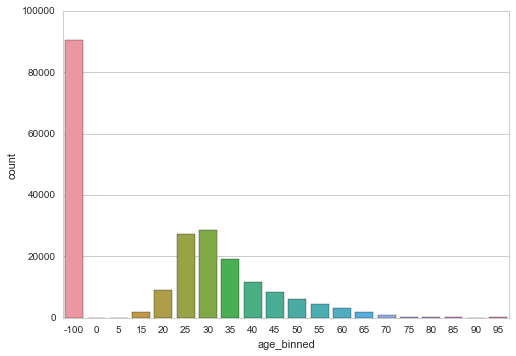

In [21]:
## Age attribute cleaning
age_dist = train_users.groupby("age", as_index=False).agg({"id":pd.Series.nunique})
age_dist ## strange values exist (1945, 120, ...)

## Age over 100 or incorrect input values(ex. 2014, 1945...) apply value '-100'. 
train_users['age']= train_users['age'].apply(lambda x: -100 if x>=100 else x)

## After preprocessing
sns.set(style="whitegrid")
train_users["age_binned"] = map(lambda x: int(x/5)*5, train_users["age"])  ## age binned by 5, (0~4, 5~9, 10~14,...)
sns.countplot(x="age_binned", data=train_users.sort_values("age_binned",ascending=1))
train_users.groupby("age_binned", as_index=False).agg({"id":pd.Series.nunique})

train_users.head()

# 3. Data exploration

### Booking Date, Create Date를 년/월/일로 파싱
### 1. 연도별, 월별로 Booking 트렌드 확인
 + 2010~2014년도까지 Booking 수 증가
 + 일반적으로 1~6월로 갈수록 점차 증가
 + 5,6월에 Booking수가 최대로 증가 후에 7~12월에 다시 감소
 + 2014년도의 경우에 다른 년도와 다르게 7월 이후 Booking이 급감

### 2. 성별, 나이대 별로 Booking 분포 확인
 + 20-30대가 주요 이용 고객
 + Gender가 unknown, 나이대 확인 불가능한 고객이 많음: age와 gender를 country_destination 예측에 주요변수로 활용하기 어려움
 + 일반적으로 여성이 남성보다 많이 사용
 
### 3. 사용 언어별 유입 제휴 채널에 대한 확인
 + 사용 언어는 영어가 대부분: 대부분 사용국가는 미국,영국,호주와 같은 영어권 국가
 + 주요 유입 채널은 Direct가 대부분이며, 그 다음은 Brand Term의 Search Engine, Non-brand Term의 Search Engine을 통한 유입 순
 + 사용언어와 제휴 채널은 단일 Attribute로는 Classification을 위한 Information이 거의 없음

### 4. 회원 가입 시 첫 사용 디바이스 분포 확인
 + 맥북 > 윈도우 기반 데스크탑 > 아이폰 > 아이패드 순
 + Facebook이나 Google 연동 기반 가입보다 기본 회원가입 비율이 높음

In [22]:
## Parsing Booking date - year/month/date

def parse_booking_date(df):
    temp = df["date_first_booking"].str.split('-').apply(Series, 1).stack()
    df['Booking_year'] = temp[:,0]
    df['Booking_month'] = temp[:,1]
    df['Booking_date'] = temp[:,2]
    
def parse_create_date(df):
    temp = df['date_account_created'].str.split('-').apply(Series,1).stack()
    df['Create_year']= temp[:,0]
    df['Create_month']= temp[:,1]
    df['Create_date']= temp[:,2]


In [23]:
parse_booking_date(train_users)
parse_create_date(train_users)
# train_users.head()

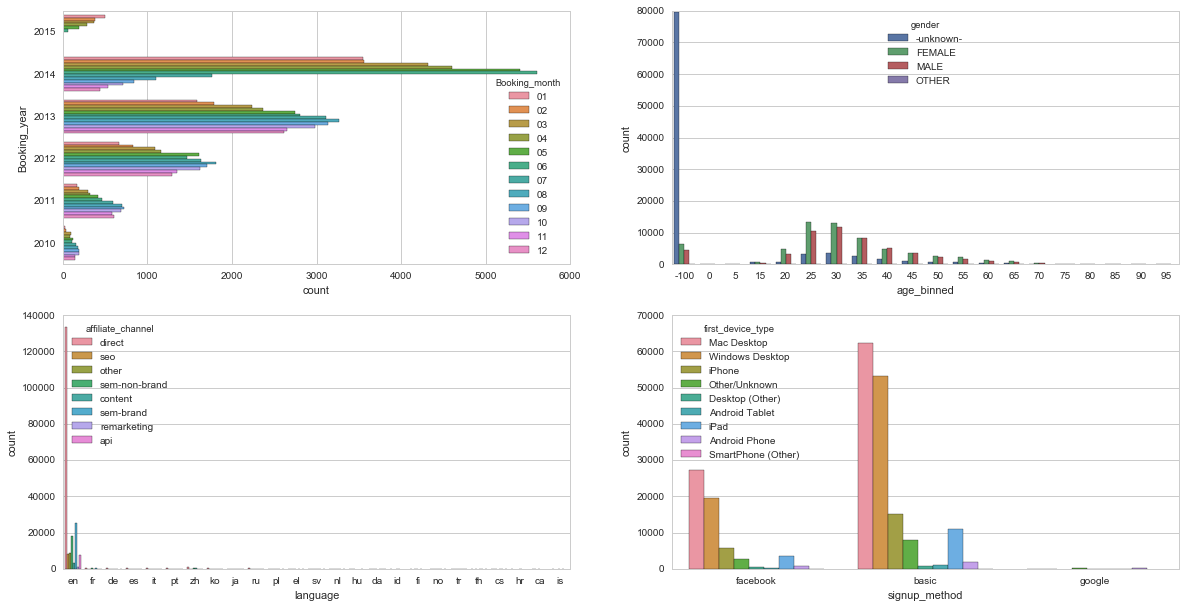

In [24]:
plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plt.subplot(221)
sns.countplot(y='Booking_year',hue='Booking_month',\
              data=train_users.sort_values(["Booking_year",'Booking_month'], ascending=[0,1]))

plt.subplot(222)
sns.countplot(x='age_binned', hue='gender', data=train_users.sort_values("age_binned",ascending=1))

plt.subplot(223)
sns.countplot(x='language', hue='affiliate_channel', data=train_users)

plt.subplot(224)
sns.countplot(x='signup_method', hue='first_device_type', data=train_users)

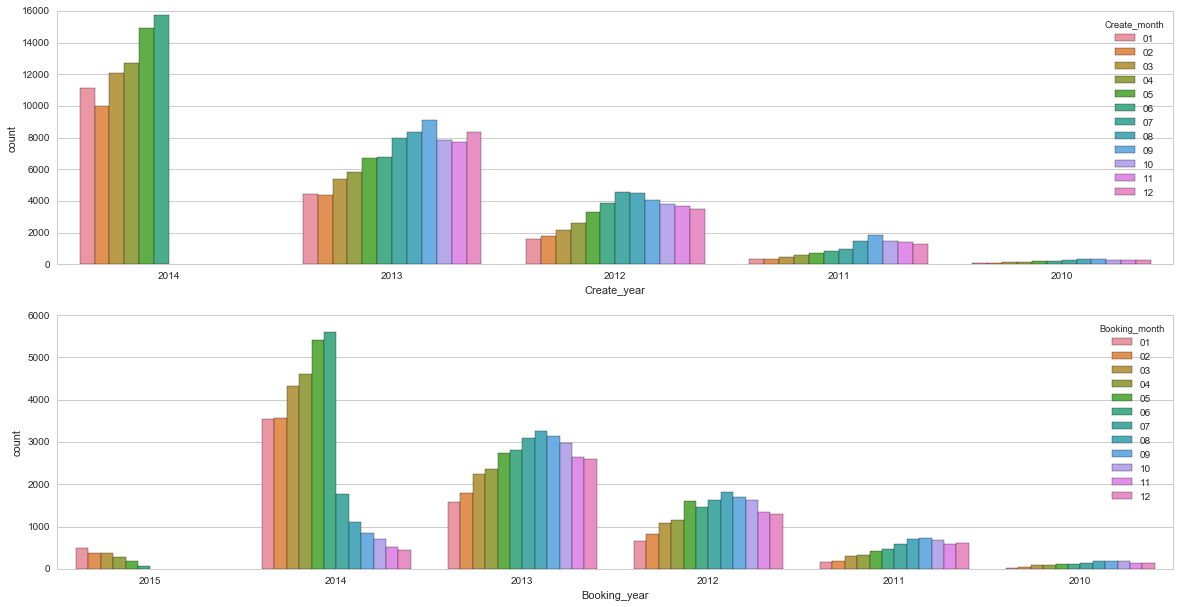

In [25]:
plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

plt.subplot(211)
sns.countplot(x='Create_year', hue='Create_month',\
              data=train_users.sort_values(["Create_year",'Create_month'], ascending=[0,1]))

plt.subplot(212)
sns.countplot(x='Booking_year', hue='Booking_month',\
              data=train_users.sort_values(['Booking_year','Booking_month'], ascending=[0,1]))

## 특성에 따른 Booking 여부 분류 확인

 + 성별에 따른 Booking/Non-booking 구분: 일반적으로 성별 구분이 Known일때보다, Unknown일 경우엔 Booking의 확률이 낮다.
 + 회원가입 방법에 따른 구분: 유의미한 차이가 보이지 않음
 + 유입 제휴 채널에 따른 구분: SEO를 통한 유입의 경우 Booking확률이 높음, brand, non-brand SEM보다 Direct를 통한 Booking확률이 더 높음
 + 언어에 따른 구분: 대부분 영어 사용국가가 이용, 큰 의미 없음

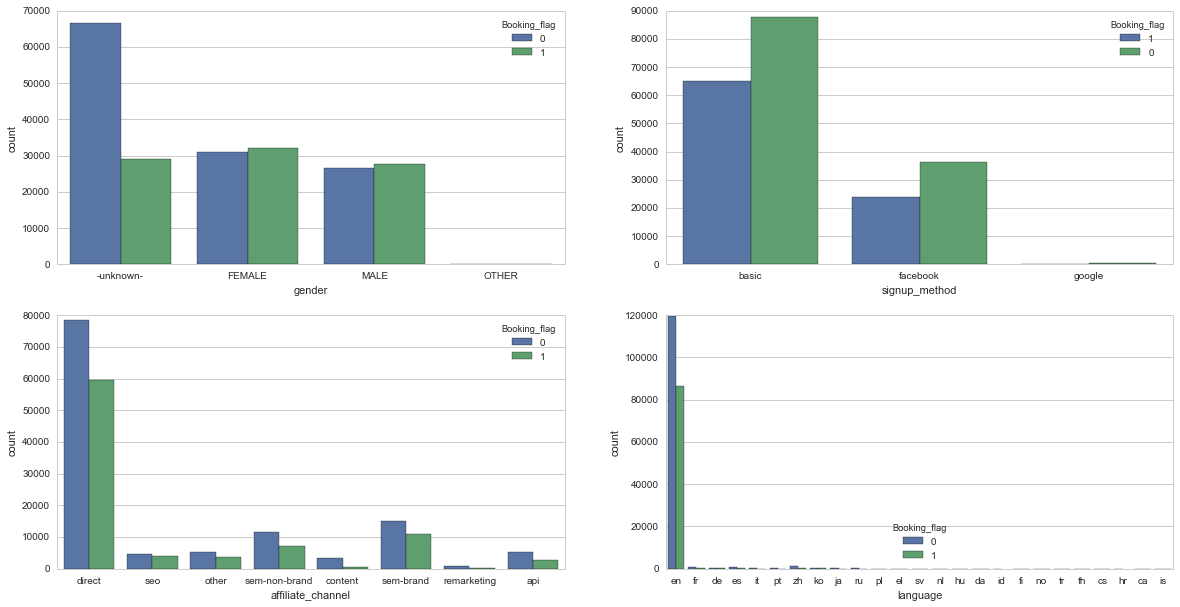

In [26]:
train_users['Booking_flag'] = train_users['date_first_booking'].apply(lambda x: 1 if x <> -100 else 0)

plt.subplots(nrows=2, ncols=2, figsize=(20,10))

plt.subplot(221)
sns.countplot(x='gender', hue='Booking_flag', data=train_users.sort_values('gender', ascending=1))

plt.subplot(222)
sns.countplot(x='signup_method', hue='Booking_flag', data=train_users.sort_values('signup_method', ascending=1))

plt.subplot(223)
sns.countplot(x='affiliate_channel', hue='Booking_flag', data=train_users)

plt.subplot(224)
sns.countplot(x='language', hue='Booking_flag', data=train_users)

In [27]:
def crosstab_prob(df, a, b):
    temp = pd.crosstab(df[a], df[b])
    temp['Booking_prob'] = temp[1]/(temp[0]+temp[1])
    return temp


Booking_prob_gender=crosstab_prob(train_users, 'gender','Booking_flag')
Booking_prob_signup_method = crosstab_prob(train_users, 'signup_method', 'Booking_flag')
Booking_prob_lang = crosstab_prob(train_users, 'language', 'Booking_flag')
Booking_prob_affiliate_channel = crosstab_prob(train_users, 'affiliate_channel', 'Booking_flag')
Booking_prob_first_device = crosstab_prob(train_users, 'first_device_type', 'Booking_flag')
Booking_prob_age_binned = crosstab_prob(train_users, 'age_binned', 'Booking_flag')

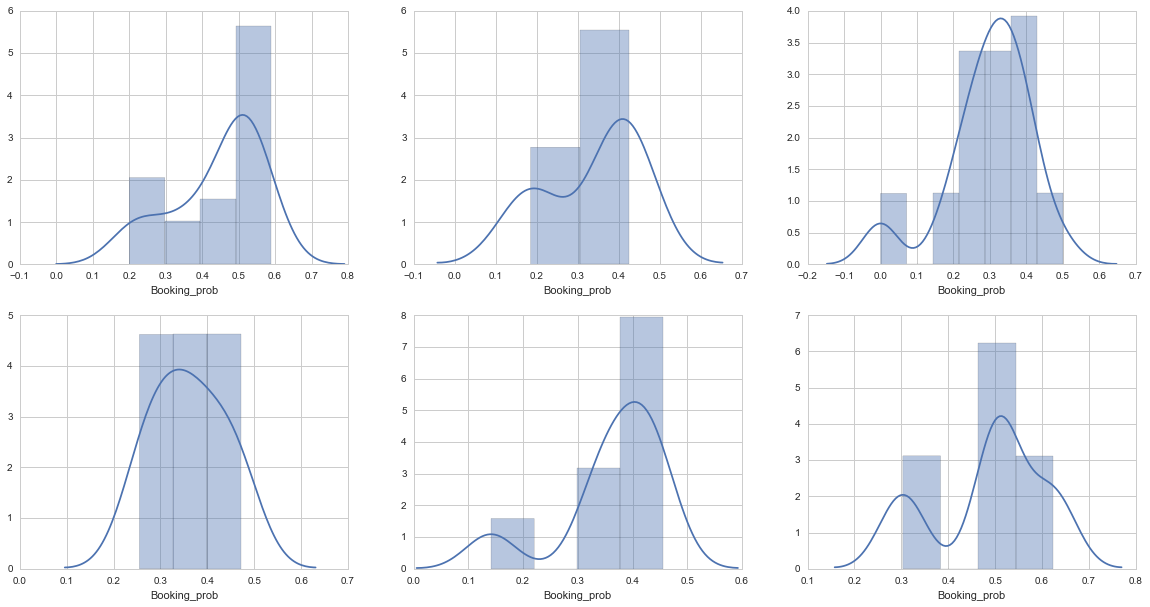

In [28]:
plt.subplots(nrows=2, ncols=3, figsize=(20,10))

plt.subplot(231)
sns.distplot(Booking_prob_age_binned['Booking_prob'])

plt.subplot(232)
sns.distplot(Booking_prob_signup_method['Booking_prob'])

plt.subplot(233)
sns.distplot(Booking_prob_lang['Booking_prob'])

plt.subplot(234)
sns.distplot(Booking_prob_first_device['Booking_prob'])

plt.subplot(235)
sns.distplot(Booking_prob_affiliate_channel['Booking_prob'])

plt.subplot(236)
sns.distplot(Booking_prob_gender['Booking_prob'])

In [29]:
session_stat = sessions.groupby('user_id', as_index=False).agg({'action':pd.Series.nunique,\
                                                                'secs_elapsed':pd.Series.sum,\
                                                                'device_type':pd.Series.nunique})
user_join_session = pd.merge(train_users, session_stat, how='left', left_on='id', right_on='user_id',\
                            suffixes=('_x','_y'), copy=True)

user_join_session.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,Booking_month,Booking_date,Create_year,Create_month,Create_date,Booking_flag,user_id,action,secs_elapsed,device_type
0,gxn3p5htnn,2010-06-28,20090319043255,-100,-unknown-,-100,facebook,0,en,direct,...,NaN,NaN,2010,06,28,0,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,-100,MALE,38,facebook,0,en,seo,...,NaN,NaN,2011,05,25,0,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,...,08,02,2010,09,28,1,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,...,09,08,2011,12,05,1,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,...,02,18,2010,09,14,1,NaN,NaN,NaN,NaN


## Session 데이터를 통한 접속 시간 분포 확인

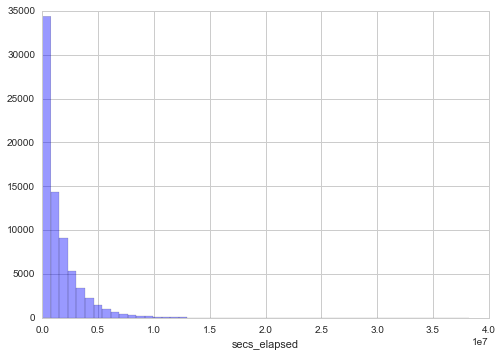

In [30]:
temp = user_join_session[pd.notnull(user_join_session['user_id'])==True]
temp.head()

# ax = sns.boxplot(x="secs_elapsed", y="Booking_flag", data=temp)
sns.distplot(temp['secs_elapsed'], kde=False, color='b')

# g = sns.lmplot(x="action", y="secs_elapsed", col="Booking_flag", data=temp)

## Dimension Reduction
### Train_users데이터에서 유의미하지 않게 생각되는 데이터 및 Modeling에 사용할 수 없는 데이터 제거
+ date_account_created, timestamp_first_active, Booking year/month/date, id, Booking 여부(country_destination과 중복), first booking date 제거

In [31]:
train_users.info()

X=train_users.drop(['date_account_created','timestamp_first_active','Booking_year','Booking_month'\
                    ,'Booking_date','id','Booking_flag','country_destination','date_first_booking'], axis=1)
y=train_users['Booking_flag']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 24 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         213451 non-null object
gender                     213451 non-null object
age                        213451 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    213451 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
age_binned                 213451 non-null int64
Booking_year               88908 non-null

In [32]:
from sklearn import preprocessing

for f in train_users.columns:
    if f == "country_destination" or f == "id": continue
    if train_users[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(train_users[f].values)))
        train_users[f] = lbl.transform(list(train_users[f].values))

train_users.info()
train_users.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 24 columns):
id                         213451 non-null object
date_account_created       213451 non-null int64
timestamp_first_active     213451 non-null int64
date_first_booking         213451 non-null int64
gender                     213451 non-null int64
age                        213451 non-null float64
signup_method              213451 non-null int64
signup_flow                213451 non-null int64
language                   213451 non-null int64
affiliate_channel          213451 non-null int64
affiliate_provider         213451 non-null int64
first_affiliate_tracked    213451 non-null int64
signup_app                 213451 non-null int64
first_device_type          213451 non-null int64
first_browser              213451 non-null int64
country_destination        213451 non-null object
age_binned                 213451 non-null int64
Booking_year               213451 non-null int64
Boo

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_browser,country_destination,age_binned,Booking_year,Booking_month,Booking_date,Create_year,Create_month,Create_date,Booking_flag
0,gxn3p5htnn,170,20090319043255,0,0,-100,1,0,5,2,...,8,NDF,-100,6,12,31,0,5,27,0
1,820tgsjxq7,501,20090523174809,0,2,38,1,0,5,7,...,8,NDF,35,6,12,31,1,4,24,0
2,4ft3gnwmtx,262,20090609231247,193,1,56,0,3,5,2,...,21,US,55,0,7,1,0,8,27,1
3,bjjt8pjhuk,695,20091031060129,959,1,42,1,0,5,2,...,17,other,40,2,8,7,1,11,4,1
4,87mebub9p4,248,20091208061105,34,0,41,0,0,5,2,...,8,US,40,0,1,17,0,8,13,1


In [33]:
train_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 24 columns):
id                         213451 non-null object
date_account_created       213451 non-null int64
timestamp_first_active     213451 non-null int64
date_first_booking         213451 non-null int64
gender                     213451 non-null int64
age                        213451 non-null float64
signup_method              213451 non-null int64
signup_flow                213451 non-null int64
language                   213451 non-null int64
affiliate_channel          213451 non-null int64
affiliate_provider         213451 non-null int64
first_affiliate_tracked    213451 non-null int64
signup_app                 213451 non-null int64
first_device_type          213451 non-null int64
first_browser              213451 non-null int64
country_destination        213451 non-null object
age_binned                 213451 non-null int64
Booking_year               213451 non-null int64
Boo

In [34]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


X=train_users.drop(['id','date_account_created','timestamp_first_active','date_first_booking',\
                    'first_affiliate_tracked','signup_app','age_binned','Booking_year','Booking_month',\
                    'Booking_date','Create_year','Create_month','Create_date','country_destination','affiliate_channel',\
                    'affiliate_provider','first_browser','first_device_type','Booking_flag'], axis=1)
y=train_users['Booking_flag']

clf = RandomForestClassifier(n_estimators=500, max_depth=None,min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X, y)
print scores.mean()  

X.head()

0.671381465959


,gender,age,signup_method,signup_flow,language
0,0,-100,1,0,5
1,2,38,1,0,5
2,1,56,0,3,5
3,1,42,1,0,5
4,0,41,0,0,5


In [35]:
print clf.fit(X,y)

print clf.feature_importances_
# print clf.class_weight
# print clf.criterion
# print clf.estimator_params
# print clf.predict
print clf.oob_score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
[ 0.13526998  0.54430533  0.17391217  0.11580945  0.03070307]
False


## Session  데이터 전처리 및 확인
### 

In [36]:
sessions['action_detail'] = sessions['action_detail'].fillna('-100')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,-100,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,-100,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,-100,Windows Desktop,435


0.0
1799977.0
[nan 'click' 'data' 'view' 'submit' 'message_post' '-unknown-'
 'booking_request' 'partner_callback' 'booking_response' 'modify']


/Users/KimHongTae/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


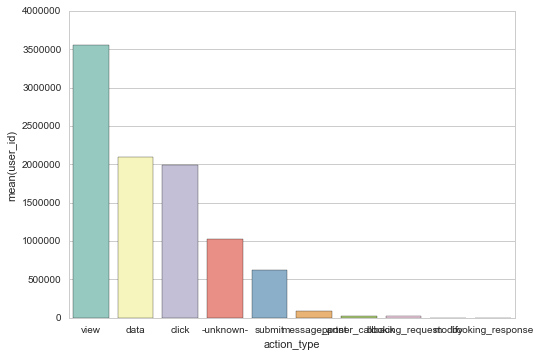

In [37]:
print sessions['secs_elapsed'].min()
print sessions['secs_elapsed'].max()
print sessions['action_type'].unique()
# print sessions['action'].unique()

temp  = sessions.groupby('action_type', as_index=False).agg({'user_id':pd.Series.count}).sort('user_id', ascending=0)
sns.barplot('action_type', 'user_id', palette="Set3", data=temp)

In [38]:
sex_age_dest_group = age_gender.groupby(['gender','age_bucket','country_destination'], as_index=False)\
.agg({'population_in_thousands':pd.Series.sum})

sex_age_sum = sex_age_dest_group.groupby(['gender','age_bucket'], as_index=False)\
['population_in_thousands'].sum()
sex_age_sum.head()

sex_age_dest_group = pd.merge(sex_age_dest_group, sex_age_sum, how='left', on=['gender', 'age_bucket'])
sex_age_dest_group['prob'] = sex_age_dest_group['population_in_thousands_x'] / sex_age_dest_group['population_in_thousands_y']


age_min =[]
age_max =[]
binned_age = []

for idx in sex_age_dest_group['age_bucket']:
    if '-' in idx:
        age_min.append(idx.split('-')[0])
        age_max.append(idx.split('-')[1])
        binned_age.append(int(idx.split('-')[0])/5)
    
    else:
        age_min.append(999)
        age_max.append(1000)
        binned_age.append(20)


sex_age_dest_group['age_min'] = age_min
sex_age_dest_group['age_max'] = age_max
sex_age_dest_group['binned_age'] = binned_age

sex_age_dest_group.head()

,gender,age_bucket,country_destination,population_in_thousands_x,population_in_thousands_y,prob,age_min,age_max,binned_age
0,female,0-4,AU,781,20861,0.037438,0,4,0
1,female,0-4,CA,991,20861,0.047505,0,4,0
2,female,0-4,DE,1713,20861,0.082115,0,4,0
3,female,0-4,ES,1198,20861,0.057428,0,4,0
4,female,0-4,FR,1938,20861,0.092901,0,4,0


In [39]:
import sys

print(sessions.head())
print(sessions.info())
print(sessions.apply(lambda x: x.nunique(),axis=0))

#sessions['action'] = sessions['action'].fillna('999')
#data roll-up
#secs_elapsed
grpby = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grpby.columns = ['user_id','secs_elapsed']

# agg = grpby['secs_elapsed'].agg({'time_spent' : np.sum})

#action
#print(sessions.action_type.value_counts())
#print(sessions.groupby(['action_type'])['user_id'].nunique().reset_index())
action_type = pd.pivot_table(sessions, index = ['user_id'],columns = ['action_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()
action_type = action_type.drop(['booking_response'],axis=1)
#print(action_type.head())

#print(sessions.groupby(['device_type'])['user_id'].nunique().reset_index())
#print(sessions.groupby(['user_id'])['device_type'].nunique().reset_index())
device_type = pd.pivot_table(sessions, index = ['user_id'],columns = ['device_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()
device_type = device_type.drop(['Blackberry','Opera Phone','iPodtouch','Windows Phone'],axis=1)
#device_type = device_type.replace(device_type.iloc[:,1:]>0,1)
print(device_type.info())

sessions_data = pd.merge(action_type,device_type,on='user_id',how='inner')

sessions_data = pd.merge(sessions_data,grpby,on='user_id',how='inner')
print(sessions_data.head())

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                 -100   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                 -100   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                 -100   

       device_type  secs_elapsed  
0  Windows Desktop           319  
1  Windows Desktop         67753  
2  Windows Desktop           301  
3  Windows Desktop         22141  
4  Windows Desktop           435  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 564.4+ MB
None
user_id          135483
action              359
action_type          10
act

In [42]:
import numpy as np
import pandas as pd
# import sklearn.preprocessing.LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model as lm
# from sklearn.neural_network import MLPClassifier

# from xgboost.sklearn import XGBClassifier
# import xgboost as xgb
np.random.seed(0)

#Loading data
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users 2.csv')
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
id_test = df_test['id']
piv_train = df_train.shape[0]

#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

#Merge levenshtein_distance to US
countries_piv = pd.pivot_table(countries,index='destination_language ',values='language_levenshtein_distance')
countries_piv.index = ['de','en','fr','it','nl','pt','es']
countries_piv = Series.to_frame(countries_piv)
countries_piv['lang']=countries_piv.index

df_all = pd.merge(df_all,countries_piv, how='left', left_on='language',right_on='lang')
df_all = df_all.drop(['lang'], axis=1)
df_all['language_levenshtein_distance'].fillna(150)


## join session aggregation data
df_all = pd.merge(df_all,sessions_data, how='left', left_on='id', right_on='user_id')

#Removing id and date_first_booking
df_all = df_all.drop(['id','user_id', 'date_first_booking'], axis=1)
#Filling nan
df_all = df_all.fillna(-10)

#####Feature engineering#######
#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)

#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)


#Age
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

#Splitting train and test
vals = df_all.values
X = vals[:piv_train]

le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = vals[piv_train:]
# weight_array_test = weight_array[piv_train:]

#Classifier
xgb = RandomForestClassifier(n_estimators=200, max_depth=20,min_samples_split=3, random_state=0)
# xgb = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0,\
#                                  max_depth=20, random_state=0).fit(X, y)

xgb.fit(X, y)
y_pred = xgb.predict_proba(X_test)



### Logistic Regression
clf = lm.LogisticRegression(penalty='l2', dual=False,\
                                      tol=0.0001, C=1.5, fit_intercept=True,\
                                      intercept_scaling=1, class_weight='balanced',\
                                      random_state=None)
clf.fit(X, y)
y_pred_logit = clf.predict_proba(X_test)



#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries

for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [43]:
sub.to_csv('sub.csv',index=False)

In [ ]:
## initialize population prob. matrix for df_test
weight_array = []
temp_idx = 0
NDF_other_weight = [0.58495059, 0.04740926]

for idx in list(zip(df_all['age'],df_all['gender'])):
    if idx[1] == 'FEMALE':
        if idx[0] != '100+' and idx[0] != -1:
            age_gender_cond = np.logical_and(sex_age_dest_group['gender'] =='female',\
                                             sex_age_dest_group['binned_age'] == int(idx[0]/5))
            weight_array.append([0.36764015*i for i in sex_age_dest_group[age_gender_cond]['prob']])
            weight_array[temp_idx] += NDF_other_weight
        else:
            weight_array.append((1/12)*np.ones((12)))
    
    elif idx[1] == 'MALE':
        if idx[0] != '100+' and idx[0] != -1:
            age_gender_cond = np.logical_and(sex_age_dest_group['gender'] =='male',\
                                             sex_age_dest_group['binned_age'] == int(idx[0]/5))
            weight_array.append([0.36764015*i for i in sex_age_dest_group[age_gender_cond]['prob']])
            weight_array[temp_idx] += NDF_other_weight

        else:
            weight_array.append((1/12)*np.ones((12)))
    
    else:
        weight_array.append((1/12)*np.ones((12)))
    
    temp_idx += 1

    
for idx in y_pred:
    idx = 0.9*idx

for idx in weight_array_test:
    [0.1*i for i in idx]
    
for idx in np.arange(df_test.shape[0]):
    y_pred[idx] += weight_array_test[idx]

In [ ]:
feat_import = xgb.feature_importances_.argsort()[::-1]
print feat_import
col = df_all.columns
col_import = col[feat_import]
col_import